In [1]:
import sys
sys.path.insert(0, "/home/spiffical/data/spiffical/")

import time
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import keras
import keras.backend as K
from keras.models import Model, load_model
from keras import backend as K

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

from StarNet.nn.utilities.load_data import load_data_from_h5
from StarNet.nn.utilities.data_augmentation import mask_tellurics

Using TensorFlow backend.


In [11]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """ 
     
    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."
        
    if window_len<3:
        return x
    
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
    
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')
    
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y  

#### Define all necessary paths

In [24]:
# Grab desired model
#model_path = 'Runs/StarNet_2018-10-31_run1/' + 'weights.best.h5'
#model_path = 'StarNet_2019-03-05_run5/weights.best.h5'  # trained on 4 labels
model_path = 'Runs/StarNet_2018-07-27_run1/model_weights.h5'  # trained on 7 labels

# Folders for synthetic and real data
test_data_path = '/home/spiffical/data/spiffical/realspec/UVES/UVES_GE_MW_4835-5395_updated.h5'
data_folder_synth = '/vmstorage/projects/gaiaeso/spectra/intrigoss/UVES_4835-5395/' 

# Define parameters to retrieve from the h5 data file
targets = ['teff', 'logg', 'M_H', 'a_M']#, 'v_rot', 'v_rad', 'VT']
spec_name = 'spectra_starnetnorm'

#### Grab necessary spectra data

In [25]:
data_file = data_folder_synth + 'INTRIGOSS_gaiaeso_UVES-4835-5395_7labels_testset.h5'
#data_file = data_folder_synth + 'INTRIGOSS_gaiaeso_UVES-4835-5395_7labels_noradialvel.h5'
#data_file = data_folder_synth + 'INTRIGOSS_UVES-4835-5395_vrad0_vrot0_training.h5'

indices = np.arange(0,300,1)
data = load_data_from_h5(data_file=data_file,
                         indices=indices,
                         targetname=targets,
                         specname=spec_name)

X_synth, y_synth, noise_synth, wave_grid = data.X, data.y, data.noise, data.wave_grid

# Mask telluric lines
#X_synth = mask_tellurics('telluric_lines.txt', X_synth, wave_grid)

# Zero-point bad values
X_synth[X_synth>1.03]=0
X_synth[X_synth<0]=0

X_synth = np.array(X_synth)
y_synth = np.array(y_synth)
indx_highT = y_synth[:,0] > 5500
indx_lowT = y_synth[:,0] <= 5500
X_synth_highT = X_synth[indx_highT]
X_synth_lowT = X_synth[indx_lowT]
y_synth_highT = y_synth[indx_highT]
y_synth_lowT = y_synth[indx_lowT]

IOError: [Errno 2] No such file or directory: ''

In [16]:
K.clear_session()  # Need this line to avoid issues of starting a new graph in the Tensorflow session
model = load_model(model_path)
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer
    # To do so, create a new model sharing the same layers untill the last dense
    fModel = Model(inputs=input_tensor, outputs = model.layers[-1].output)
    target_tensor = fModel(input_tensor)
    
    xs1 = X_synth_highT
    xs1 = xs1.reshape(len(xs1), xs1.shape[1], 1)
    xs2 = X_synth_lowT
    xs2 = xs2.reshape(len(xs2), xs2.shape[1], 1)
    #baseline = np.ones(xs[0].shape)
    baseline = np.mean(xs, axis=0)
    
    deeplift_dict_7labels_highT = dict()
    deeplift_dict_7labels_lowT = dict()
    t0 = time.time()
    for i, target in enumerate(targets):
    
        # Initialize list for masking the output (in order to target a particular output node)
        ys = [[0]*np.shape(target_tensor)[1]]
        ys[0][i] = 1
    
        deeplift_highT = de.explain('deeplift', target_tensor * ys, input_tensor, xs1, baseline=baseline)
        deeplift_lowT = de.explain('deeplift', target_tensor * ys, input_tensor, xs2, baseline=baseline)
        
        deeplift_dict_7labels_highT[target] = deeplift_highT
        deeplift_dict_7labels_lowT[target] = deeplift_lowT
    t1 = time.time()
    print 'This took %.1f seconds!' % (t1-t0)

DeepExplain: running "deeplift" explanation method (5)
Model with multiple inputs:  False
DeepExplain: running "deeplift" explanation method (5)
Model with multiple inputs:  False
DeepExplain: running "deeplift" explanation method (5)
Model with multiple inputs:  False
DeepExplain: running "deeplift" explanation method (5)
Model with multiple inputs:  False
DeepExplain: running "deeplift" explanation method (5)
Model with multiple inputs:  False
DeepExplain: running "deeplift" explanation method (5)
Model with multiple inputs:  False
DeepExplain: running "deeplift" explanation method (5)
Model with multiple inputs:  False
DeepExplain: running "deeplift" explanation method (5)
Model with multiple inputs:  False
This took 166.6 seconds!


<IPython.core.display.Javascript object>


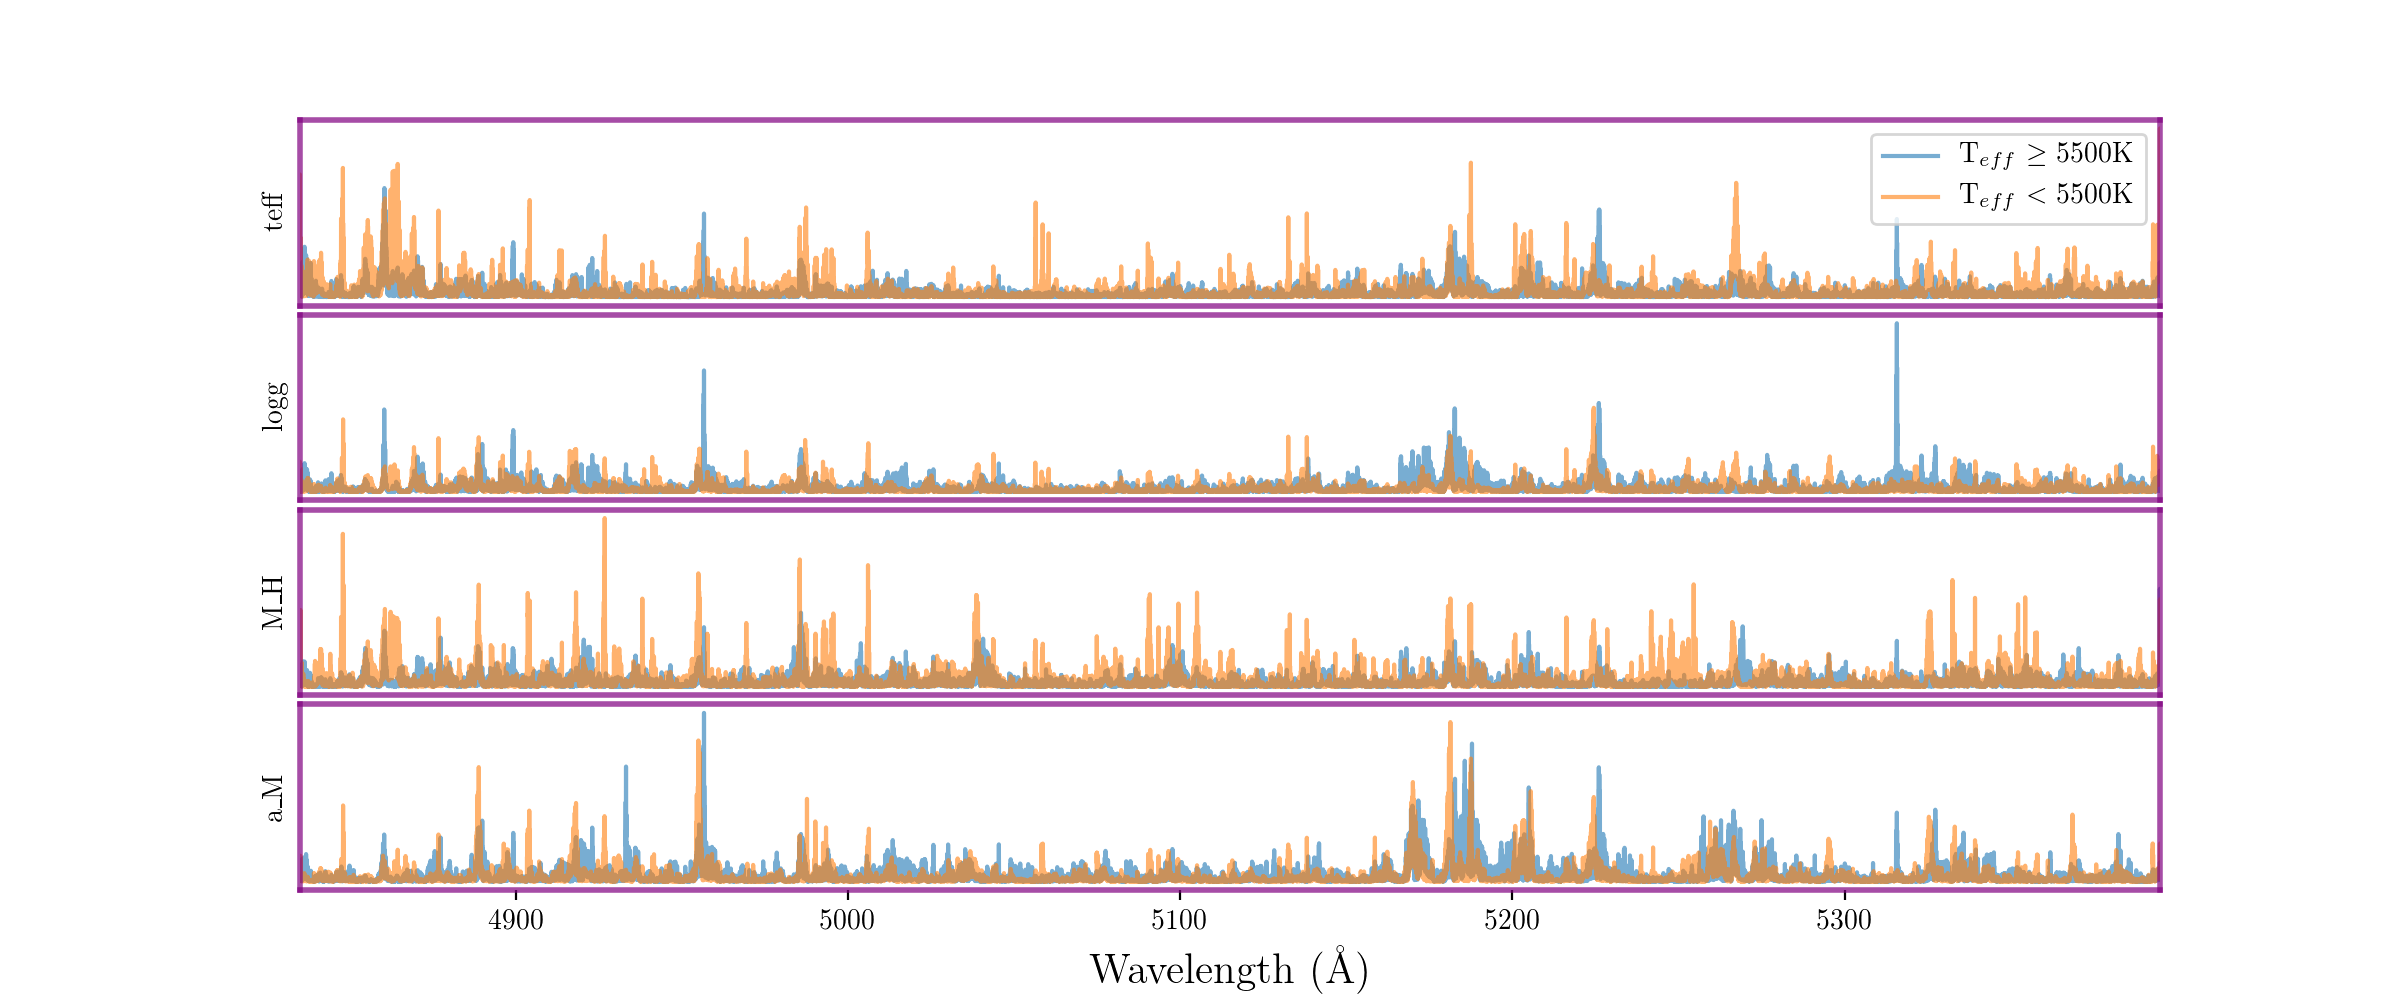

In [23]:
%matplotlib notebook
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

window_len = 5
x = smooth(wave_grid, window_len=window_len)
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

fig, axes = plt.subplots(nrows=len(targets), figsize=(12,5), sharex=True)
for i, target in enumerate(targets):
    ax = axes[i]
    y = smooth(np.abs(deeplift_dict_7labels_highT[target][0]).flatten(), window_len=window_len)
    #ax.imshow(y[np.newaxis,:], cmap=cmaps[2], aspect="auto", extent=extent)
    ax.plot(x, y, alpha=0.6, label=r'T$_{eff}$ $\geq$ 5500K')
    y = smooth(np.abs(deeplift_dict_7labels_lowT[target][0]).flatten(), window_len=window_len)
    ax.plot(x, y, alpha=0.6, label=r'T$_{eff}$ $<$ 5500K')
    ax.set_ylabel(target.replace('_', '\_'))
    ax.set_yticks([])
    if i==0:
        ax.legend(loc=0)
    if i<len(targets)-1:
        ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off') # labels along the bottom edge are off)
    plt.setp(ax.spines.values(), color='purple', alpha=0.7, lw=2)
    ax.set_xlim(extent[0], extent[1])

plt.xlabel('Wavelength (\AA)',fontsize=15)
plt.subplots_adjust(wspace=0, hspace=0.05)
plt.show()

<IPython.core.display.Javascript object>


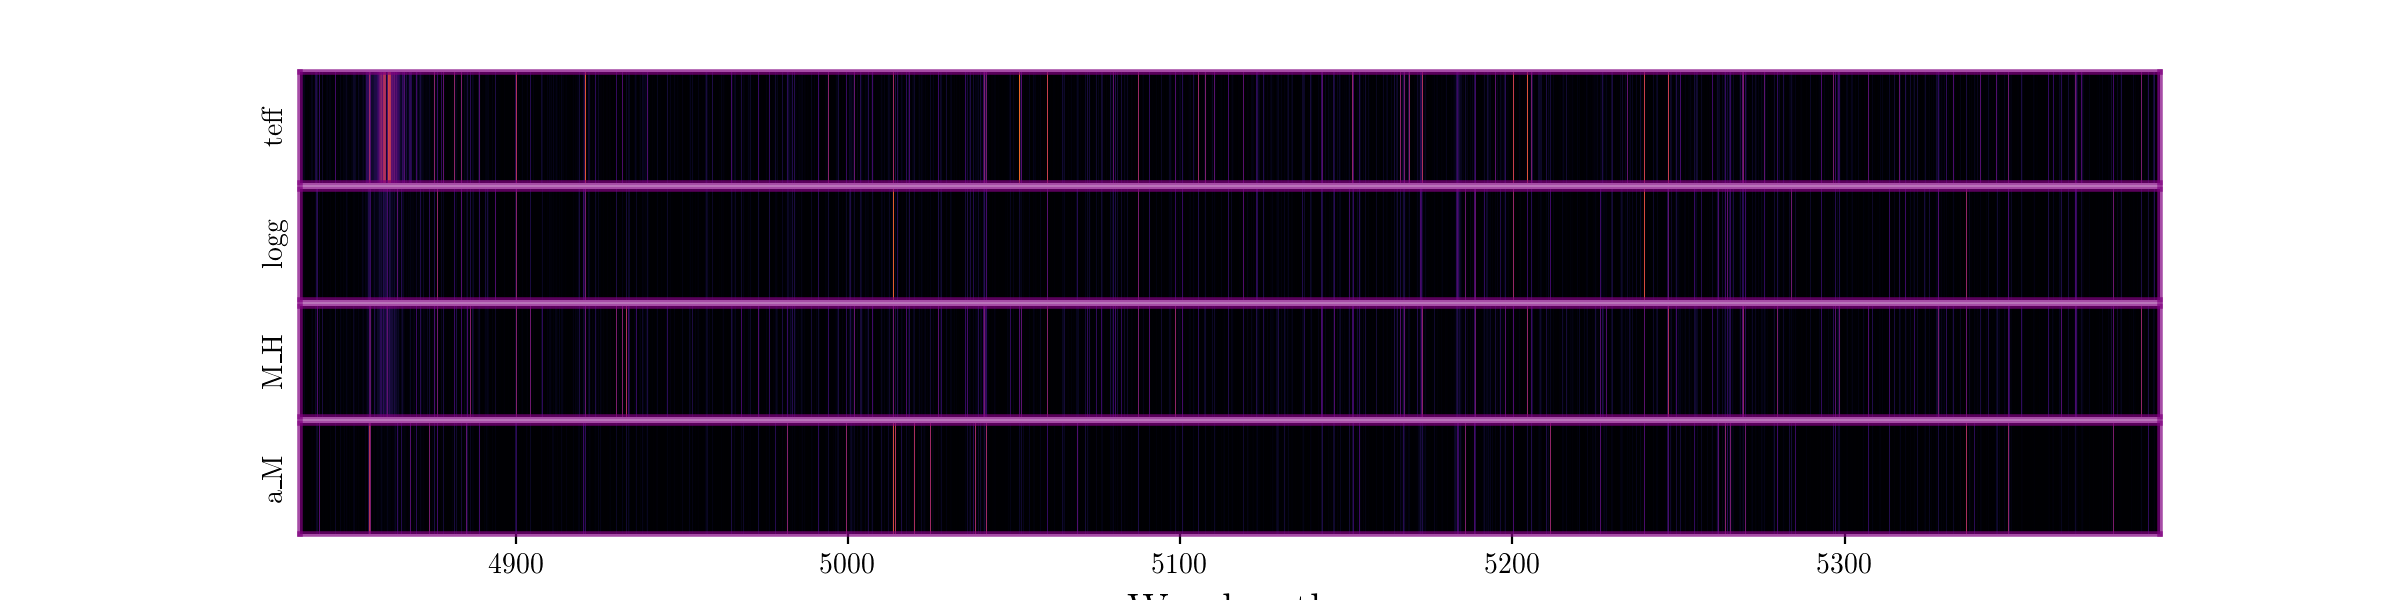

In [42]:
%matplotlib notebook
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

x = smooth(wave_grid, window_len=5)
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

fig, axes = plt.subplots(nrows=len(targets), figsize=(12,3), sharex=True)
for i, target in enumerate(targets):
    ax = axes[i]
    y = smooth(np.mean(np.abs(deeplift_dict[target]),axis=0).flatten(), window_len=5)
    ax.imshow(y[np.newaxis,:], cmap=cmaps[2], aspect="auto", extent=extent)
    #ax.plot(x, y, alpha=0.6)
    ax.set_ylabel(target.replace('_', '\_'))
    ax.set_yticks([])
    if i<len(targets)-1:
        ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off') # labels along the bottom edge are off)
    plt.setp(ax.spines.values(), color='purple', alpha=0.7, lw=2)
    ax.set_xlim(extent[0], extent[1])

plt.xlabel('Wavelength',fontsize=15)
plt.subplots_adjust(wspace=0, hspace=0.05)
plt.show()

In [26]:
%matplotlib notebook
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

window_len = 5
x = smooth(wave_grid, window_len=window_len)
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

fig, axes = plt.subplots(nrows=len(targets), figsize=(12,5), sharex=True)
for i, target in enumerate(targets):
    ax = axes[i]
    y1 = smooth(np.mean(np.abs(deeplift_dict_7labels[target]),axis=0).flatten(), window_len=window_len)
    #y = smooth(np.abs(deeplift_dict_7labels[target][0]).flatten(), window_len=1)
    #ax.imshow(y[np.newaxis,:], cmap=cmaps[2], aspect="auto", extent=extent)
    y2 = smooth(np.mean(np.abs(deeplift_dict_4labels[target]),axis=0).flatten(), window_len=window_len)
    #y = smooth(np.abs(deeplift_dict_4labels[target][0]).flatten(), window_len=1)
    y3 = smooth(baseline.flatten(), window_len=window_len)/max(baseline)
    
    # Normalize between 0 and 1
    y1max = max(y1)
    y2max = max(y2)
    y1/=y1max
    y2/=y2max
    
    
    ax.plot(x, y1, alpha=0.6, label='trained on 7 labels')
    ax.plot(x, y2, alpha=0.6, label='trained on 4 labels')
    ax.plot(x, y3, alpha=1.0, color='black', lw=0.5)
    #y = X_synth_highT[0]/max(X_synth_highT[0])
    #y/=max(y)
    #ax.plot(x, y, alpha=0.6, color='green', lw=0.5)
    ax.set_ylabel(target.replace('_', '\_'))
    ax.set_yticks([])
    if i==0:
        ax.legend(loc=0)
    if i<len(targets)-1:
        ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off') # labels along the bottom edge are off)
    plt.setp(ax.spines.values(), color='purple', alpha=0.7, lw=2)
    ax.set_xlim(extent[0], extent[1])

plt.xlabel('Wavelength (\AA)',fontsize=15)
plt.subplots_adjust(wspace=0, hspace=0.05)
plt.show()

<IPython.core.display.Javascript object>

NameError: name 'deeplift_dict_4labels' is not defined